**기본 설정 & 임포트 / 데이터 스캔 및 윈도잉**

In [49]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v3"                  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()           # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일; 13-class)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN = 30      # 2초 창 (15fps * 2s)
STRIDE  = 3       # 약 0.2초 간격 (15fps에서 3프레임)
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()

# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            if arr.ndim != 2:
                print(f"[warn] skip non-2D: {npy}, shape={arr.shape}")
                continue
            T, F = arr.shape
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

print("총 manifest:", len(manifest))
if len(manifest) == 0:
    raise RuntimeError("manifest가 비었습니다. 데이터 경로/구조를 확인하세요.")

# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)

# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    if arr.ndim != 2 or arr.shape[1] != FEAT_DIM:
        print(f"[warn] Skip due to wrong dim: {m['path']}, shape={arr.shape}")
        continue

    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)  - 현재 학습엔 미사용(옵션)
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)  # (옵션) 현재 미사용
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)

# === 13→3 매핑 ===
labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {l: ('왼쪽' if l.startswith('왼쪽') else '중앙' if l.startswith('중앙') else '오른쪽') for l in labels_np}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}
CLASS_NAMES  = ['왼쪽','중앙','오른쪽']

def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])

# 미리 3클래스 타깃 전체 계산(폴드 내 인덱싱만 수행)
y3_all = map_y_to_3(y)

# === 스케일러 fit 유틸 (활성 프레임만) ===
from sklearn.preprocessing import StandardScaler
def fit_scaler_on_active(X_train, F, hand_dims=42, eps=1e-7):
    Xtr_flat = X_train.reshape(-1, F)
    H = min(hand_dims, F)
    mask = (np.abs(Xtr_flat[:, :H]).sum(axis=1) > eps)
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    return scaler

# === 플롯 유틸 ===
import matplotlib.pyplot as plt
from matplotlib import font_manager

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure(); plt.plot(H.get('loss', []),     label='loss'); plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure(); plt.plot(H['accuracy'], label='accuracy'); plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])
    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


총 manifest: 654
Feature dims found: [48]
Clips: 654, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48
Windows kept: 26808, dropped_short: 0, dropped_inactive: 0
X shape: (26808, 30, 48) M shape: (26808, 30, 1) y shape: (26808,)


**태스크 라벨(왼쪽/오른쪽/중앙(pos),위/아래(ud))생성**

In [50]:
# === 13→태스크 라벨 매핑 (pos=왼/중/오, ud=아래/위/NA) ===
import numpy as np

POS_NAMES = ['왼쪽','중앙','오른쪽']   # head #1
UD_NAMES  = ['아래','위']            # head #2

labels_np = np.array(KOREAN_LABELS, dtype=object)

def _pos_from_label(lab: str) -> int:
    if lab.startswith('왼쪽'):   return 0
    if lab.startswith('중앙'):   return 1
    if lab.startswith('오른쪽'): return 2
    raise ValueError(f"Unexpected label for pos: {lab}")

def _ud_from_label(lab: str) -> int:
    # 씹는면
    if '씹는면' in lab:
        return 1 if '위' in lab else 0
    # 구개측은 위쪽
    if '구개측' in lab:
        return 1
    # 설측은 아래쪽
    if '설측' in lab:
        return 0
    # 협측은 NA
    return -1

# 전체 샘플에 대해 태스크 라벨 생성
y_pos_all = np.array([_pos_from_label(labels_np[i]) for i in y], dtype=np.int64)
y_ud_all  = np.array([_ud_from_label(labels_np[i])  for i in y], dtype=np.int64)

# ud 유효/무효 마스크 (1:유효, 0:무효)
ud_valid_mask_all = (y_ud_all != -1).astype(np.float32)

# Keras는 -1 라벨 불가 → 더미 0으로 대체하고, 손실은 sample_weight로 마스킹
y_ud_all_clipped = np.where(y_ud_all == -1, 0, y_ud_all)


**GPU 설정**

In [51]:
# === GPU 메모리 점진 할당 & 체크(단일) ===
import tensorflow as tf

def setup_and_check_gpu():
    print("TF version:", tf.__version__)
    print("Built with CUDA:", tf.test.is_built_with_cuda())

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("set_memory_growth 실패:", e)
        logical = tf.config.list_logical_devices('GPU')
        names = []
        for gpu in gpus:
            try:
                info = tf.config.experimental.get_device_details(gpu)
                names.append(info.get('device_name', gpu.name))
            except:
                names.append(getattr(gpu, 'name', 'GPU'))
        print(f"GPU 인식됨: 물리 {len(gpus)}개 / 논리 {len(logical)}개")
        print("GPU 이름:", names)
    else:
        print("GPU 미인식 → CPU로 학습합니다.")

setup_and_check_gpu()

# TensorFlow seed 고정
tf.random.set_seed(SEED)


TF version: 2.10.0
Built with CUDA: True
GPU 인식됨: 물리 1개 / 논리 1개
GPU 이름: ['NVIDIA GeForce RTX 4070']


**멀티태스크 모델 빌더(공유 인코더 + pos/ud 두 헤드)**

In [53]:
# === 멀티태스크 모델 빌더 (공유 인코더 + pos/ud 두 헤드) ===
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def build_multitask_model(input_shape):
    """
    공유 인코더 + pos(3), ud(2) 두 헤드
    """
    inp = layers.Input(shape=input_shape, name='inp')

    # --- 공유 인코더 (기존 단일태스크와 동일 설정) ---
    x = layers.GaussianNoise(0.01, name='enc_noise')(inp)
    x = layers.SpatialDropout1D(0.2, name='enc_sdrop')(x)

    x = layers.GRU(
        96, return_sequences=True, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru1'
    )(x)
    x = layers.GRU(
        64, return_sequences=False, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru2'
    )(x)

    x = layers.BatchNormalization(name='enc_bn')(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name='enc_fc')(x)
    x = layers.Dropout(0.5, name='enc_drop')(x)

    # --- Head #1: pos(왼/중/오) ---
    pos_out = layers.Dense(3, activation='softmax', name='pos')(x)

    # --- Head #2: ud(아래/위) ---
    ud_out  = layers.Dense(2, activation='softmax', name='ud')(x)

    model = tf.keras.Model(inp, [pos_out, ud_out])

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={'pos': tf.keras.losses.SparseCategoricalCrossentropy(),
              'ud':  tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'pos': ['accuracy'], 'ud': ['accuracy']},
        loss_weights={'pos': 1.0, 'ud': 1.0}
    )
    return model


# === 멀티태스크 모델 요약 출력 ===
tmp = build_multitask_model(input_shape=(SEQ_LEN, FEAT_DIM))
tmp.summary(line_length=120, expand_nested=False, show_trainable=True)


Model: "model"
___________________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            Trainable  
 inp (InputLayer)                      [(None, 30, 48)]           0             []                                      Y          
                                                                                                                                   
 enc_noise (GaussianNoise)             (None, 30, 48)             0             ['inp[0][0]']                           Y          
                                                                                                                                   
 enc_sdrop (SpatialDropout1D)          (None, 30, 48)             0             ['enc_noise[0][0]']                     Y          
                                                             

**모델 학습**

Epoch 1/27
378/378 [==============================] - 5s 10ms/step - loss: 1.3864 - pos_loss: 0.8611 - ud_loss: 0.4822 - pos_accuracy: 0.6710 - ud_accuracy: 0.6754 - val_loss: 0.6911 - val_pos_loss: 0.3174 - val_ud_loss: 0.3306 - val_pos_accuracy: 0.9024 - val_ud_accuracy: 0.8563 - lr: 3.0000e-04
Epoch 2/27
378/378 [==============================] - 3s 9ms/step - loss: 0.9639 - pos_loss: 0.5305 - ud_loss: 0.3901 - pos_accuracy: 0.8138 - ud_accuracy: 0.7267 - val_loss: 0.6321 - val_pos_loss: 0.2363 - val_ud_loss: 0.3523 - val_pos_accuracy: 0.8946 - val_ud_accuracy: 0.7373 - lr: 3.0000e-04
Epoch 3/27
378/378 [==============================] - 3s 8ms/step - loss: 0.8111 - pos_loss: 0.4287 - ud_loss: 0.3385 - pos_accuracy: 0.8535 - ud_accuracy: 0.7531 - val_loss: 0.5676 - val_pos_loss: 0.2079 - val_ud_loss: 0.3156 - val_pos_accuracy: 0.9306 - val_ud_accuracy: 0.7460 - lr: 3.0000e-04
Epoch 4/27
378/378 [==============================] - 3s 8ms/step - loss: 0.7088 - pos_loss: 0.3679 - ud_los

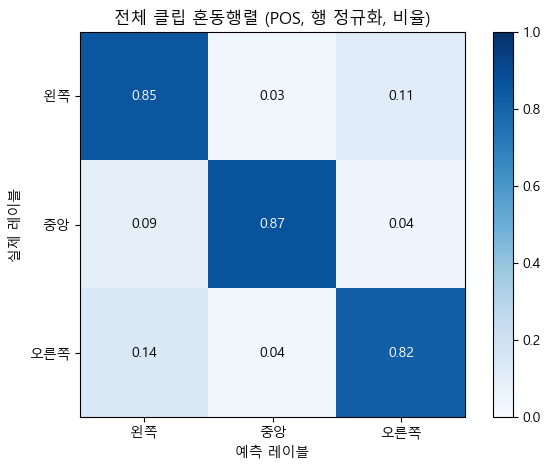


==== OVERALL (클립, UD) ====
Overall 클립 Acc: 0.768 | Balanced Acc: 0.768
              precision    recall  f1-score   support

          아래      0.752     0.806     0.778       252
           위      0.787     0.730     0.757       248

    accuracy                          0.768       500
   macro avg      0.769     0.768     0.768       500
weighted avg      0.769     0.768     0.768       500



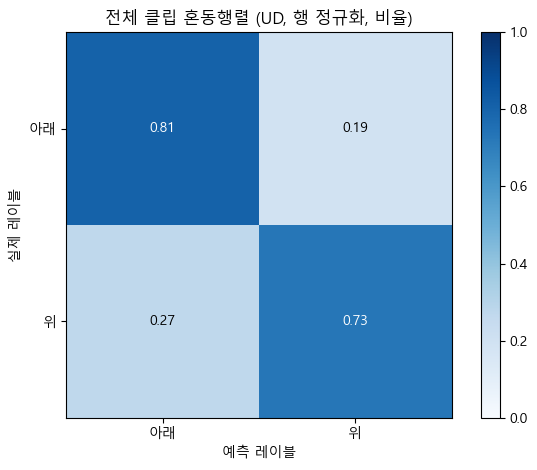

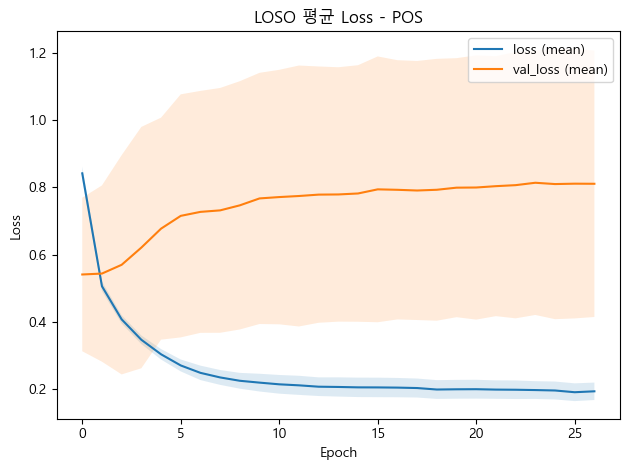

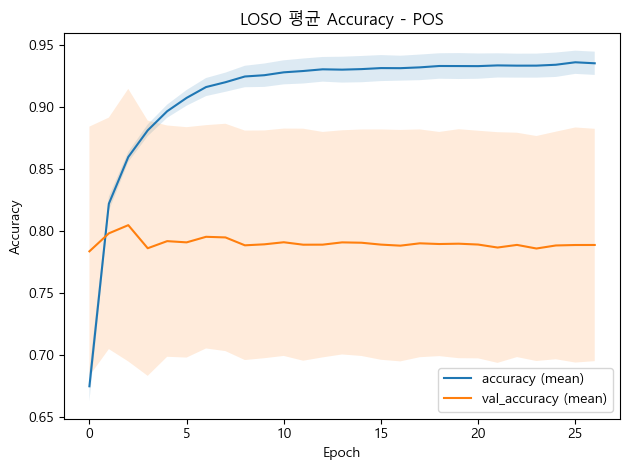

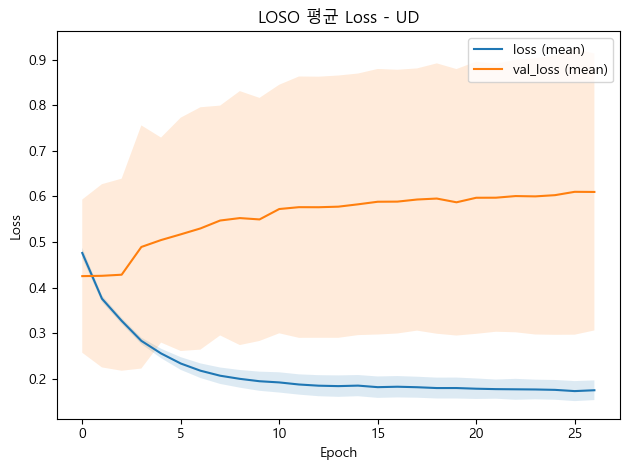

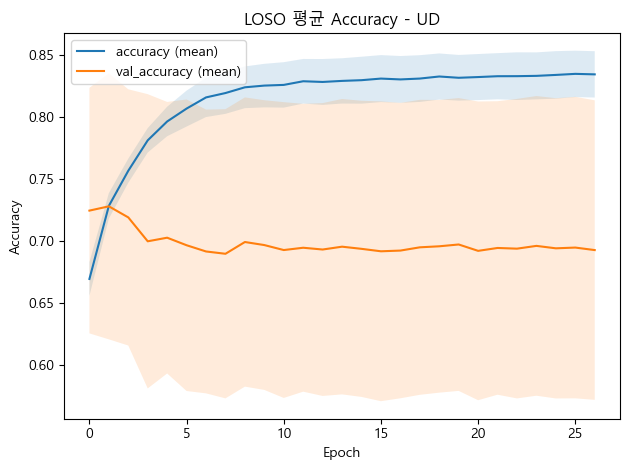

In [54]:
# === LOSO 멀티태스크 학습/평가 (pos + ud, class_weight 미사용: sample_weight로 통일) ===
import os, gc
import numpy as np
from collections import defaultdict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# ----- 옵션 -----
EPOCHS = 27
BATCH_SIZE = 64
RLR_PATIENCE = 2
PLOT_LAST_FOLD_CURVES = False  # 마지막 폴드 곡선 X, 대신 헤드별 평균 곡선 O

# 클래스 이름 (이미 앞에서 정의돼 있어도 동일하게 사용)
POS_NAMES = ['왼쪽','중앙','오른쪽']
UD_NAMES  = ['아래','위']

# histories 평균 플로팅(헤드별)
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves_head(histories, head_name='pos'):
    """헤드별 평균 loss/acc 곡선 그리기 (LOSO 평균 + std band)"""
    loss_key, vloss_key = f'{head_name}_loss', f'val_{head_name}_loss'
    acc_key,  vacc_key  = f'{head_name}_accuracy', f'val_{head_name}_accuracy'

    loss_list     = [h.get(loss_key, []) for h in histories]
    val_loss_list = [h.get(vloss_key, []) for h in histories]
    mean_loss, std_loss         = _nanmean_along_epochs(loss_list)
    mean_val_loss, std_val_loss = _nanmean_along_epochs(val_loss_list)

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title(f'LOSO 평균 Loss - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    acc_list     = [h.get(acc_key, []) for h in histories]
    val_acc_list = [h.get(vacc_key, []) for h in histories]
    mean_acc, std_acc         = _nanmean_along_epochs(acc_list)
    mean_val_acc, std_val_acc = _nanmean_along_epochs(val_acc_list)

    if mean_acc is not None:
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title(f'LOSO 평균 Accuracy - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# 행 정규화 혼동행렬(이미 전 셀에 plot_confmat_ratio가 있으면 그걸 써도 OK)
def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

# ----- 준비 -----
persons = np.array([m["person"] for m in meta])
logo = LeaveOneGroupOut()
F = X.shape[-1]
HAND_DIMS = min(42, F)

histories = []
pos_win_accs, pos_clip_accs = [], []
ud_win_accs,  ud_clip_accs  = [], []
# 전체(모든 폴드) 클립 단위 예측/정답 누적
pos_clip_true_all, pos_clip_pred_all = [], []
ud_clip_true_all,  ud_clip_pred_all  = [], []

fold_no = 0
total_folds = len(np.unique(persons))

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1
    tf.keras.backend.clear_session(); gc.collect()

    # --- Split ---
    Xtr, Xva = X[train_idx], X[val_idx]
    y_pos_tr, y_pos_va = y_pos_all[train_idx], y_pos_all[val_idx]
    y_ud_tr,  y_ud_va  = y_ud_all_clipped[train_idx], y_ud_all_clipped[val_idx]
    sw_ud_tr, sw_ud_va = ud_valid_mask_all[train_idx], ud_valid_mask_all[val_idx]  # 1:유효, 0:NA

    # --- 스케일러 (train 활성 프레임 기반 fit → 전체 변환) ---
    scaler = fit_scaler_on_active(Xtr, F, hand_dims=HAND_DIMS, eps=1e-7)
    Xtr_s = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape)
    Xva_s = scaler.transform(Xva.reshape(-1, F)).reshape(Xva.shape)

    # --- 클래스 불균형 보정: per-sample weight ---
    # POS
    pos_counts = np.bincount(y_pos_tr, minlength=3)
    pos_median = float(np.median(pos_counts[pos_counts > 0])) if (pos_counts > 0).any() else 1.0
    pos_weights_per_class = np.array([pos_median / max(c, 1) for c in pos_counts], dtype=np.float32)
    sw_pos_tr = np.ones(len(y_pos_tr), dtype=np.float32)
    for cls_idx, w in enumerate(pos_weights_per_class):
        sw_pos_tr[y_pos_tr == cls_idx] = w

    # UD (유효 샘플만 카운트)
    ud_tr_valid = y_ud_tr[sw_ud_tr.astype(bool)]
    if len(ud_tr_valid) > 0:
        ud_counts = np.bincount(ud_tr_valid, minlength=2)
        ud_median = float(np.median(ud_counts[ud_counts > 0])) if (ud_counts > 0).any() else 1.0
        ud_weights_per_class = np.array([ud_median / max(c, 1) for c in ud_counts], dtype=np.float32)
    else:
        ud_weights_per_class = np.array([1.0, 1.0], dtype=np.float32)

    sw_ud_tr_full = np.ones(len(y_ud_tr), dtype=np.float32)
    for cls_idx, w in enumerate(ud_weights_per_class):
        sw_ud_tr_full[y_ud_tr == cls_idx] = w
    sw_ud_tr_full *= sw_ud_tr.astype(np.float32)  # NA=0 마스킹

    # --- 모델 ---
    model = build_multitask_model(input_shape=(Xtr_s.shape[1], Xtr_s.shape[2]))

    # 콜백
    best_w_path = f'_tmp_mtl_best_fold{fold_no:02d}.weights.h5'
    cbs = [
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.ModelCheckpoint(filepath=best_w_path, monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    ]

    # --- 학습 ---
    sw_valid = {
        'pos': np.ones(len(Xva_s), dtype=np.float32),
        'ud' : sw_ud_va.astype(np.float32)  # UD는 NA=0으로 마스킹
    }
    history = model.fit(
        Xtr_s,
        {'pos': y_pos_tr, 'ud': y_ud_tr},
        validation_data=(Xva_s, {'pos': y_pos_va, 'ud': y_ud_va}, sw_valid),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        sample_weight={'pos': sw_pos_tr, 'ud': sw_ud_tr_full},
        callbacks=cbs, verbose=1
    )

    # 베스트 가중치 로드
    if os.path.exists(best_w_path):
        model.load_weights(best_w_path)
        try: os.remove(best_w_path)
        except: pass

    histories.append(history.history)

    # --- 예측 ---
    p_pos_va, p_ud_va = model.predict(Xva_s, verbose=0)
    y_pos_pred = p_pos_va.argmax(1)
    y_ud_pred  = p_ud_va.argmax(1)

    # 윈도우 Acc
    pos_win_accs.append(accuracy_score(y_pos_va, y_pos_pred))
    if sw_ud_va.sum() > 0:
        mask = sw_ud_va.astype(bool)
        ud_win_accs.append(accuracy_score(y_ud_va[mask], y_ud_pred[mask]))

    # --- 클립 집계(확률 평균) ---
    val_meta = [meta[i] for i in val_idx]

    # POS
    bucket_pos, bucket_pos_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        bucket_pos[m["src"]].append(p_pos_va[i])
        bucket_pos_y[m["src"]] = y_pos_va[i]
    pos_P_clip, pos_Y_clip = [], []
    for src, ps in bucket_pos.items():
        pos_P_clip.append(np.mean(ps, axis=0))
        pos_Y_clip.append(bucket_pos_y[src])
    pos_clip_pred = np.argmax(np.vstack(pos_P_clip), axis=1)
    pos_clip_accs.append(accuracy_score(pos_Y_clip, pos_clip_pred))
    pos_clip_true_all.append(np.array(pos_Y_clip))
    pos_clip_pred_all.append(pos_clip_pred)

    # UD (유효 클립만)
    bucket_ud, bucket_ud_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        if sw_ud_va[i] > 0.5:
            bucket_ud[m["src"]].append(p_ud_va[i])
            bucket_ud_y[m["src"]] = y_ud_va[i]
    if len(bucket_ud) > 0:
        ud_P_clip, ud_Y_clip = [], []
        for src, ps in bucket_ud.items():
            ud_P_clip.append(np.mean(ps, axis=0))
            ud_Y_clip.append(bucket_ud_y[src])
        ud_clip_pred = np.argmax(np.vstack(ud_P_clip), axis=1)
        ud_clip_accs.append(accuracy_score(ud_Y_clip, ud_clip_pred))
        ud_clip_true_all.append(np.array(ud_Y_clip))
        ud_clip_pred_all.append(ud_clip_pred)

# ===== 집계 출력 =====
pos_clip_true_all = np.concatenate(pos_clip_true_all, axis=0) if len(pos_clip_true_all)>0 else np.array([])
pos_clip_pred_all = np.concatenate(pos_clip_pred_all, axis=0) if len(pos_clip_pred_all)>0 else np.array([])
ud_clip_true_all  = np.concatenate(ud_clip_true_all, axis=0)  if len(ud_clip_true_all)>0  else np.array([])
ud_clip_pred_all  = np.concatenate(ud_clip_pred_all, axis=0)  if len(ud_clip_pred_all)>0  else np.array([])

print("\n==== POS(왼/중/오) ====")
print(f"Win Acc:  {np.mean(pos_win_accs):.3f} ± {np.std(pos_win_accs):.3f}")
print(f"Clip Acc: {np.mean(pos_clip_accs):.3f} ± {np.std(pos_clip_accs):.3f}")

if len(ud_win_accs) > 0:
    print("\n==== UD(아래/위, 유효 샘플만) ====")
    print(f"Win Acc:  {np.mean(ud_win_accs):.3f} ± {np.std(ud_win_accs):.3f}")
if len(ud_clip_accs) > 0:
    print(f"Clip Acc: {np.mean(ud_clip_accs):.3f} ± {np.std(ud_clip_accs):.3f}")

# ---- 헤드별 Overall(클립) 리포트 & 혼동행렬 ----
from sklearn.metrics import balanced_accuracy_score

# POS
if pos_clip_true_all.size > 0:
    pos_overall_acc = accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    pos_bal_acc     = balanced_accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    print("\n==== OVERALL (클립, POS) ====")
    print(f"Overall 클립 Acc: {pos_overall_acc:.3f} | Balanced Acc: {pos_bal_acc:.3f}")
    print(classification_report(pos_clip_true_all, pos_clip_pred_all, target_names=POS_NAMES, digits=3))
    cm_pos = confusion_matrix(pos_clip_true_all, pos_clip_pred_all, labels=[0,1,2])
    plot_confmat_ratio(cm_pos, POS_NAMES, '전체 클립 혼동행렬 (POS, 행 정규화, 비율)')

# UD
if ud_clip_true_all.size > 0:
    ud_overall_acc = accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    ud_bal_acc     = balanced_accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    print("\n==== OVERALL (클립, UD) ====")
    print(f"Overall 클립 Acc: {ud_overall_acc:.3f} | Balanced Acc: {ud_bal_acc:.3f}")
    print(classification_report(ud_clip_true_all, ud_clip_pred_all, target_names=UD_NAMES, digits=3))
    cm_ud = confusion_matrix(ud_clip_true_all, ud_clip_pred_all, labels=[0,1])
    plot_confmat_ratio(cm_ud, UD_NAMES, '전체 클립 혼동행렬 (UD, 행 정규화, 비율)')

# ---- 헤드별 LOSO 평균 곡선 ----
plot_mean_training_curves_head(histories, head_name='pos')
plot_mean_training_curves_head(histories, head_name='ud')


**멀티태스크 배포 아티팩트 저장 셀**

In [59]:
# === 멀티태스크 배포(프로덕션용) 학습 & 저장 ===
# 전제: X, y_pos_all, y_ud_all_clipped, ud_valid_mask_all, FEAT_DIM, SEQ_LEN, HAND_DIMS,
#       build_multitask_model(), fit_scaler_on_active()가 앞서 정의되어 있음
import os, json, gc
import numpy as np
import tensorflow as tf
from joblib import dump

SAVE_DIR = "deploy_mtl_v1"
os.makedirs(SAVE_DIR, exist_ok=True)

N = X.shape[0]
F = FEAT_DIM

# 1) 스케일러: 전체 데이터 활성 프레임 기준으로 fit
scaler_all = fit_scaler_on_active(X, F, hand_dims=HAND_DIMS, eps=1e-7)
X_s = scaler_all.transform(X.reshape(-1, F)).reshape(X.shape)

# 2) 간단한 hold-out 검증 분할(UD 마스크를 val에 반영하기 위함)
rng = np.random.default_rng(42)
idx = np.arange(N)
rng.shuffle(idx)
val_ratio = 0.10
val_n = max(1, int(N * val_ratio))
val_idx = idx[:val_n]
tr_idx  = idx[val_n:]

Xtr_s, Xva_s = X_s[tr_idx], X_s[val_idx]
y_pos_tr, y_pos_va = y_pos_all[tr_idx], y_pos_all[val_idx]
y_ud_tr,  y_ud_va  = y_ud_all_clipped[tr_idx], y_ud_all_clipped[val_idx]
sw_ud_tr, sw_ud_va = ud_valid_mask_all[tr_idx], ud_valid_mask_all[val_idx]

# 3) per-sample class weighting (POS/UD)
# POS
pos_counts = np.bincount(y_pos_tr, minlength=3)
pos_median = float(np.median(pos_counts[pos_counts > 0])) if (pos_counts > 0).any() else 1.0
pos_weights_per_class = np.array([pos_median / max(c, 1) for c in pos_counts], dtype=np.float32)
sw_pos_tr = np.ones(len(y_pos_tr), dtype=np.float32)
for cls_idx, w in enumerate(pos_weights_per_class):
    sw_pos_tr[y_pos_tr == cls_idx] = w

# UD (유효 샘플만 카운트)
ud_tr_valid = y_ud_tr[sw_ud_tr.astype(bool)]
if len(ud_tr_valid) > 0:
    ud_counts = np.bincount(ud_tr_valid, minlength=2)
    ud_median = float(np.median(ud_counts[ud_counts > 0])) if (ud_counts > 0).any() else 1.0
    ud_weights_per_class = np.array([ud_median / max(c, 1) for c in ud_counts], dtype=np.float32)
else:
    ud_weights_per_class = np.array([1.0, 1.0], dtype=np.float32)

sw_ud_tr_full = np.ones(len(y_ud_tr), dtype=np.float32)
for cls_idx, w in enumerate(ud_weights_per_class):
    sw_ud_tr_full[y_ud_tr == cls_idx] = w
# UD 유효도 마스킹(협측 등 NA 샘플=0)
sw_ud_tr_full *= sw_ud_tr.astype(np.float32)

# 4) 모델 빌드 & 학습
tf.keras.backend.clear_session(); gc.collect()
model_prod = build_multitask_model(input_shape=(SEQ_LEN, FEAT_DIM))

best_w_path = os.path.join(SAVE_DIR, "_tmp_best.weights.h5")
cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(filepath=best_w_path, monitor='val_loss',
                                       save_best_only=True, save_weights_only=True, verbose=0),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss',
                                     restore_best_weights=True)
]

sw_valid = {
    'pos': np.ones(len(Xva_s), dtype=np.float32),
    'ud' : sw_ud_va.astype(np.float32)  # UD는 NA=0으로 마스킹
}

hist_prod = model_prod.fit(
    Xtr_s,
    {'pos': y_pos_tr, 'ud': y_ud_tr},
    validation_data=(Xva_s, {'pos': y_pos_va, 'ud': y_ud_va}, sw_valid),
    epochs=27, batch_size=64,
    sample_weight={'pos': sw_pos_tr, 'ud': sw_ud_tr_full},
    callbacks=cbs, verbose=1
)

# 베스트 가중치 복원
if os.path.exists(best_w_path):
    model_prod.load_weights(best_w_path)
    try: os.remove(best_w_path)
    except: pass

# 5) 저장
model_path  = os.path.join(SAVE_DIR, "model_mtl.keras")
scaler_path = os.path.join(SAVE_DIR, "scaler.pkl")
cfg_path    = os.path.join(SAVE_DIR, "config.json")

model_prod.save(model_path)
dump(scaler_all, scaler_path)

cfg = {
    "seq_len": int(SEQ_LEN),
    "feat_dim": int(FEAT_DIM),
    "pos_names": ["왼쪽","중앙","오른쪽"],
    "ud_names": ["아래","위"],
    # pos×ud 조합(인덱스: pos*2 + ud) — 실시간에서 그대로 사용할 것
    "combined6_names": [
        "왼쪽-아래","왼쪽-위",
        "중앙-아래","중앙-위",
        "오른쪽-아래","오른쪽-위"
    ],
    "combine_rule": "combined_idx = pos*2 + ud",
    # 참고 메모(문서화)
    "ud_training_note": "협측(NA)은 UD 손실에서 sample_weight=0으로 마스킹하여 학습"
}
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)

print("Saved:", model_path, scaler_path, cfg_path)


Epoch 1/27
377/377 [==============================] - 5s 10ms/step - loss: 1.3876 - pos_loss: 0.8691 - ud_loss: 0.4752 - pos_accuracy: 0.6603 - ud_accuracy: 0.6896 - val_loss: 0.7372 - val_pos_loss: 0.3676 - val_ud_loss: 0.3264 - val_pos_accuracy: 0.8728 - val_ud_accuracy: 0.7866 - lr: 3.0000e-04
Epoch 2/27
377/377 [==============================] - 3s 8ms/step - loss: 0.9406 - pos_loss: 0.5182 - ud_loss: 0.3788 - pos_accuracy: 0.8197 - ud_accuracy: 0.7445 - val_loss: 0.5689 - val_pos_loss: 0.2574 - val_ud_loss: 0.2677 - val_pos_accuracy: 0.9007 - val_ud_accuracy: 0.7951 - lr: 3.0000e-04
Epoch 3/27
377/377 [==============================] - 3s 8ms/step - loss: 0.7991 - pos_loss: 0.4281 - ud_loss: 0.3269 - pos_accuracy: 0.8522 - ud_accuracy: 0.7691 - val_loss: 0.4747 - val_pos_loss: 0.2076 - val_ud_loss: 0.2228 - val_pos_accuracy: 0.9246 - val_ud_accuracy: 0.8187 - lr: 3.0000e-04
Epoch 4/27
377/377 [==============================] - 3s 8ms/step - loss: 0.6920 - pos_loss: 0.3615 - ud_los

**실시간 멀티태스크 추론 스크립트 (pos+ud → 6조합까지)**

In [62]:
# -*- coding: utf-8 -*-
"""
Realtime inference for Multitask (pos=왼/중/오, ud=아래/위)
- 15fps 리샘플링(step 프레임 평균)
- 코 원점 + 눈-눈 롤 보정 + 눈간거리 스케일 정규화
- 손 42 + 얼굴 보조 6 = 48차 (학습과 동일)
- 두 헤드 확률을 스무딩 후 pos×ud 6-클래스 조합 라벨도 동시에 출력
"""

import os, json, time
import numpy as np
import cv2
from collections import deque
from joblib import load
import tensorflow as tf
from typing import Optional

# --------- 경로 ---------
SAVE_DIR = "deploy_mtl_v1"  # 위 저장 셀과 동일 폴더
MODEL_PATH  = os.path.join(SAVE_DIR, "model_mtl.keras")
SCALER_PATH = os.path.join(SAVE_DIR, "scaler.pkl")
CFG_PATH    = os.path.join(SAVE_DIR, "config.json")

# --------- 로드 ---------
model  = tf.keras.models.load_model(MODEL_PATH)
scaler = load(SCALER_PATH)
with open(CFG_PATH, "r", encoding="utf-8") as f:
    CFG = json.load(f)

SEQ_LEN  = int(CFG["seq_len"])
FEAT_DIM = int(CFG["feat_dim"])
POS_NAMES = list(CFG["pos_names"])
UD_NAMES  = list(CFG["ud_names"])
COMBINED6_NAMES = list(CFG["combined6_names"])

# --------- 하이퍼 ---------
TARGET_FPS       = 15
ACTIVE_RATIO_MIN = 0.20
POS_SMOOTH_WIN   = 5
UD_SMOOTH_WIN    = 5
TEXT_COLOR       = (0, 255, 0)
DBG_COLOR        = (0, 255, 255)

# --------- MediaPipe ---------
try:
    import mediapipe as mp
except Exception as e:
    raise RuntimeError("pip install mediapipe 필요") from e

mp_face  = mp.solutions.face_mesh
mp_hands = mp.solutions.hands

# FaceMesh index
NOSE_TIP_IDX    = 1
LEFT_EYE_IDX    = 133
RIGHT_EYE_IDX   = 362
PHILTRUM_IDX    = 13
MOUTH_LEFT_IDX  = 61
MOUTH_RIGHT_IDX = 291

def rot2d(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]], dtype=np.float32)

def resample_step(in_fps: float, out_fps: float = TARGET_FPS) -> int:
    if in_fps is None or in_fps <= 1: return 1
    if out_fps <= 0: return 1
    return max(1, int(round(in_fps / out_fps)))

# --------- Pillow 한글 출력 ---------
from PIL import Image, ImageFont, ImageDraw
_FONT_CANDIDATES = [
    r"C:\Windows\Fonts\malgun.ttf",
    r"C:\Windows\Fonts\malgunbd.ttf",
    "/System/Library/Fonts/AppleGothic.ttf",
    "/Library/Fonts/AppleGothic.ttf",
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
]
def _pick_korean_font() -> Optional[str]:
    for p in _FONT_CANDIDATES:
        if os.path.exists(p): return p
    return None
_KOR_FONT = _pick_korean_font()
def draw_korean(img_bgr, text, org=(12,36), size=28, color=(0,255,0), stroke=2):
    if _KOR_FONT is None:
        cv2.putText(img_bgr, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
        return img_bgr
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil_im  = Image.fromarray(img_rgb)
    draw    = ImageDraw.Draw(pil_im)
    font    = ImageFont.truetype(_KOR_FONT, size)
    x, y = org
    for dx, dy in [(-stroke,0),(stroke,0),(0,-stroke),(0,stroke)]:
        draw.text((x+dx, y+dy), text, font=font, fill=(0,0,0))
    draw.text(org, text, font=font, fill=(int(color[2]), int(color[1]), int(color[0])))
    return cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)

# --------- 특징 추출 ---------
def extract_48d_feature_from_frame(frame_bgr, face_model, hand_model, flip_x_for_features=False):
    """코 원점, 눈-눈 롤 보정, 눈간 스케일 정규화 (손42 + 인중/입꼬리6)"""
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    f_res = face_model.process(rgb)
    if not f_res.multi_face_landmarks:
        return None, False
    face_lm = f_res.multi_face_landmarks[0].landmark
    le = np.array([face_lm[LEFT_EYE_IDX].x,  face_lm[LEFT_EYE_IDX].y], dtype=np.float32)
    re = np.array([face_lm[RIGHT_EYE_IDX].x, face_lm[RIGHT_EYE_IDX].y], dtype=np.float32)
    nose = np.array([face_lm[NOSE_TIP_IDX].x, face_lm[NOSE_TIP_IDX].y], dtype=np.float32)
    eye_vec = re - le
    roll = np.arctan2(float(eye_vec[1]), float(eye_vec[0]))
    R = rot2d(-roll)
    scale = float(np.linalg.norm(eye_vec) + 1e-6)
    def nrm_face(idx):
        p = np.array([face_lm[idx].x, face_lm[idx].y], dtype=np.float32) - nose
        p = (R @ p) / scale
        if flip_x_for_features: p[0] = -p[0]
        return p
    phil = nrm_face(PHILTRUM_IDX)
    mL   = nrm_face(MOUTH_LEFT_IDX)
    mR   = nrm_face(MOUTH_RIGHT_IDX)
    face_aux = np.array([phil[0], phil[1], mL[0], mL[1], mR[0], mR[1]], dtype=np.float32)

    h_res = hand_model.process(rgb)
    hand_flat = np.zeros(42, dtype=np.float32)
    hand_detected = False
    if h_res.multi_hand_landmarks:
        hand_detected = True
        pts = []
        hand = h_res.multi_hand_landmarks[0].landmark
        for i in range(21):
            p = np.array([hand[i].x, hand[i].y], dtype=np.float32) - nose
            p = (R @ p) / scale
            if flip_x_for_features: p[0] = -p[0]
            pts.extend([p[0], p[1]])
        hand_flat = np.array(pts, dtype=np.float32)
    feat = np.concatenate([hand_flat, face_aux], axis=0)
    return feat, hand_detected

# --------- 런타임 ---------
def main():
    flip_screen = True   # 보기용 화면 미러
    flip_x_feat = False  # 학습 좌/우 기준이 어긋나면 토글
    show_debug  = True

    # 버퍼
    win_buf  = deque(maxlen=SEQ_LEN)     # (48,)
    flag_buf = deque(maxlen=SEQ_LEN)     # 손 검출 여부
    pos_buf  = deque(maxlen=POS_SMOOTH_WIN)  # (3,)
    ud_buf   = deque(maxlen=UD_SMOOTH_WIN)   # (2,)

    # 리샘플링
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("웹캠을 열 수 없습니다."); return
    cam_fps = cap.get(cv2.CAP_PROP_FPS)
    step = resample_step(cam_fps, TARGET_FPS)
    raw_feat_group, raw_flag_group = [], []

    # MediaPipe
    face_model = mp_face.FaceMesh(
        static_image_mode=False, max_num_faces=1, refine_landmarks=True,
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    )
    hand_model = mp_hands.Hands(
        static_image_mode=False, max_num_hands=1,
        min_detection_confidence=0.4, min_tracking_confidence=0.4
    )

    last_pos_label = "대기중"
    last_ud_label  = "-"
    last_combined  = "-"
    last_pos_probs = np.zeros(3, dtype=np.float32)
    last_ud_probs  = np.zeros(2, dtype=np.float32)

    while True:
        ok, frame = cap.read()
        if not ok: break
        disp = cv2.flip(frame, 1) if flip_screen else frame.copy()

        feat, hand_ok = extract_48d_feature_from_frame(frame, face_model, hand_model, flip_x_for_features=flip_x_feat)

        # step 프레임 평균 → 1 타임스텝
        if feat is not None and feat.shape == (FEAT_DIM,):
            raw_feat_group.append(feat)
            raw_flag_group.append(bool(hand_ok))
            if len(raw_feat_group) >= step:
                avg_feat = np.mean(np.vstack(raw_feat_group), axis=0).astype(np.float32)
                hand_flag = (np.mean(raw_flag_group) > 0.5)
                win_buf.append(avg_feat)
                flag_buf.append(hand_flag)
                raw_feat_group.clear(); raw_flag_group.clear()

        if len(win_buf) == SEQ_LEN:
            active_ratio = float(np.mean(flag_buf))
            if active_ratio >= ACTIVE_RATIO_MIN:
                x  = np.array(win_buf, dtype=np.float32).reshape(1, SEQ_LEN, FEAT_DIM)
                xs = scaler.transform(x.reshape(-1, FEAT_DIM)).reshape(1, SEQ_LEN, FEAT_DIM)
                p_pos, p_ud = model.predict(xs, verbose=0)  # (1,3), (1,2)
                p_pos, p_ud = p_pos[0], p_ud[0]
                pos_buf.append(p_pos); ud_buf.append(p_ud)
                p_pos_s = np.mean(np.vstack(pos_buf), axis=0).astype(np.float32)
                p_ud_s  = np.mean(np.vstack(ud_buf),  axis=0).astype(np.float32)

                pos_idx = int(np.argmax(p_pos_s))
                ud_idx  = int(np.argmax(p_ud_s))
                last_pos_label = POS_NAMES[pos_idx]
                last_ud_label  = UD_NAMES[ud_idx]
                last_pos_probs = p_pos_s
                last_ud_probs  = p_ud_s

                # 6-조합 확률 = outer product
                comb_probs = np.outer(p_pos_s, p_ud_s).reshape(-1)  # 길이 6
                comb_idx   = int(np.argmax(comb_probs))
                last_combined = COMBINED6_NAMES[comb_idx]

                # 디버그 라인
                if show_debug:
                    dbg = f"act={active_ratio:.2f}  step={step}  flipX={flip_x_feat}"
                    disp = draw_korean(disp, dbg, (12, 70), size=24, color=DBG_COLOR)
            else:
                last_pos_label, last_ud_label, last_combined = "손 없음", "-", "-"

        # 텍스트 출력
        try:
            msg1 = f"POS: {last_pos_label}  [{last_pos_probs[0]:.2f} {last_pos_probs[1]:.2f} {last_pos_probs[2]:.2f}]"
            msg2 = f"UD : {last_ud_label}   [{last_ud_probs[0]:.2f} {last_ud_probs[1]:.2f}]"
            msg3 = f"COMBO(6): {last_combined}"
        except Exception:
            msg1 = f"POS: {last_pos_label}"
            msg2 = f"UD : {last_ud_label}"
            msg3 = f"COMBO(6): {last_combined}"

        disp = draw_korean(disp, msg1, (12, 32), size=28, color=TEXT_COLOR)
        disp = draw_korean(disp, msg2, (12, 64), size=28, color=TEXT_COLOR)
        disp = draw_korean(disp, msg3, (12, 96), size=28, color=(255, 200, 0))

        cv2.imshow("Realtime MTL (pos+ud)", disp)
        key = cv2.waitKey(1) & 0xFF
        if key == 27: break
        elif key in (ord('f'), ord('F')): flip_x_feat = not flip_x_feat
        elif key in (ord('d'), ord('D')): show_debug  = not show_debug
        elif key in (ord('m'), ord('M')): flip_screen = not flip_screen

    cap.release(); cv2.destroyAllWindows()
    face_model.close(); hand_model.close()

if __name__ == "__main__":
    main()
